# Electricity load forecast

> In this example we will show how to perform electricity load forecasting considering a model capable of handling multiple seasonalities (MSTL).

<a href="https://colab.research.google.com/github/Nixtla/statsforecast/blob/main/nbs/examples/ElectricityLoadForecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction

Some time series are generated from very low frequency data. These data generally exhibit multiple seasonalities. For example, hourly data may exhibit repeated patterns every hour (every 24 observations) or every day (every 24 * 7, hours per day, observations). This is the case for electricity load. Electricity load may vary hourly, e.g., during the evenings electricity consumption may be expected to increase. But also, the electricity load varies by week. Perhaps on weekends there is an increase in electrical activity.


In this example we will show how to model the two seasonalities of the time series to generate accurate forecasts in a short time. We will use hourly PJM electricity load data. The original data can be found [here](https://github.com/jnagura/Energy-consumption-prediction-analysis). 

## Libraries

In this example we will use the following libraries:
- [`StatsForecast`](https://github.com/Nixtla/statsforecast). Lightning ⚡️ fast forecasting with statistical and econometric models. Includes the MSTL model for multiple seasonalities.
- [`DatasetsForecast`](https://github.com/Nixtla/datasetsforecast). Used to evaluate the performance of the forecasts.
- [`Prophet`](https://github.com/facebook/prophet). Benchmark model developed by Facebook.
- [`NeuralProphet`](https://github.com/ourownstory/neural_prophet). Deep Learning version of `Prophet`. Used as benchark.

In [ ]:
%%capture
!pip install statsforecast
!pip install datasetsforecast
!pip install prophet
!pip install "neuralprophet[live]"

## Forecast using Multiple Seasonalities

### Electricity Load Data

According to the [dataset's page](https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption),

> PJM Interconnection LLC (PJM) is a regional transmission organization (RTO) in the United States. It is part of the Eastern Interconnection grid operating an electric transmission system serving all or parts of Delaware, Illinois, Indiana, Kentucky, Maryland, Michigan, New Jersey, North Carolina, Ohio, Pennsylvania, Tennessee, Virginia, West Virginia, and the District of Columbia. The hourly power consumption data comes from PJM's website and are in megawatts (MW).

Let's take a look to the data.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

pd.plotting.register_matplotlib_converters()
plt.rc("figure", figsize=(10, 8))
plt.rc("font", size=10)

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/jnagura/Energy-consumption-prediction-analysis/master/PJM_Load_hourly.csv')
df.columns = ['ds', 'y']
df.insert(0, 'unique_id', 'PJM_Load_hourly')
df['ds'] = pd.to_datetime(df['ds'])
df = df.sort_values(['unique_id', 'ds']).reset_index(drop=True)
df.tail()

,unique_id,ds,y
32891,PJM_Load_hourly,2001-12-31 20:00:00,36392.0
32892,PJM_Load_hourly,2001-12-31 21:00:00,35082.0
32893,PJM_Load_hourly,2001-12-31 22:00:00,33890.0
32894,PJM_Load_hourly,2001-12-31 23:00:00,32590.0
32895,PJM_Load_hourly,2002-01-01 00:00:00,31569.0


<matplotlib.axes._subplots.AxesSubplot>

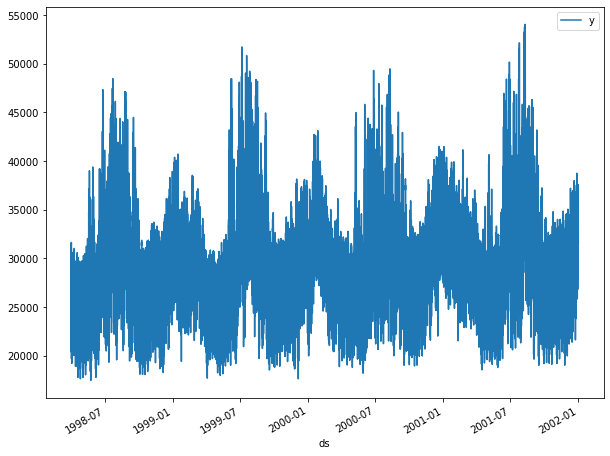

In [ ]:
df.plot(x='ds', y='y')

We clearly observe that the time series exhibits seasonal patterns. Moreover, the time series contains `32,896` observations, so it is necessary to use very computationally efficient methods to display them in production.

### MSTL model

The `MSTL` (Multiple Seasonal-Trend decomposition using LOESS) model, originally developed by [Kasun Bandara, Rob J Hyndman and Christoph Bergmeir](https://arxiv.org/abs/2107.13462), decomposes the time series in multiple seasonalities using a Local Polynomial Regression (LOESS). Then it forecasts the trend using a custom non-seasonal model and each seasonality using a `SeasonalNaive` model.

`StatsForecast` contains a fast implementation of the `MSTL` model. Also, the decomposition of the time series can be calculated.

In [ ]:
from statsforecast import StatsForecast
from statsforecast.models import MSTL, AutoARIMA, SeasonalNaive
from statsforecast.utils import AirPassengers as ap

/usr/local/lib/python3.7/dist-packages/statsforecast/core.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


First we must define the model parameters. As mentioned before, the electricity load presents seasonalities every 24 hours (Hourly) and every 24 * 7 (Daily) hours. Therefore, we will use `[24, 24 * 7]` as the seasonalities that the MSTL model receives. We must also specify the manner in which the trend will be forecasted. In this case we will use the `AutoARIMA` model.

In [ ]:
mstl = MSTL(
    season_length=[24, 24 * 7], # seasonalities of the time series 
    trend_forecaster=AutoARIMA() # model used to forecast trend
)

Once the model is instantiated, we have to instantiate the `StatsForecast` class to create forecasts. 

In [ ]:
sf = StatsForecast(
    models=[mstl], # model used to fit each time series 
    freq='H', # frequency of the data
)

#### Fit the model

Afer that, we just have to use the `fit` method to fit each model to each time series.

In [ ]:
sf = sf.fit(df=df)

#### Decompose the time series in multiple seasonalities

Once the model is fitted, we can access the decomposition using the `fitted_` attribute of `StatsForecast`. This attribute stores all relevant information of the fitted models for each of the time series. 


In this case we are fitting a single model for a single time series, so by accessing the fitted_ location [0, 0] we will find the relevant information of our model. The `MSTL` class generates a `model_` attribute that contains the way the series was decomposed.

In [ ]:
sf.fitted_[0, 0].model_

,data,trend,seasonal24,seasonal168,remainder
0,22259.0,26183.898892,-5215.124554,609.000432,681.225229
1,21244.0,26181.599305,-6255.673234,603.823918,714.250011
2,20651.0,26179.294886,-6905.329895,636.820423,740.214587
3,20421.0,26176.985472,-7073.420118,615.825999,701.608647
4,20713.0,26174.670877,-7062.395760,991.521912,609.202971
...,...,...,...,...,...
32891,36392.0,33123.552727,4387.149171,-488.177882,-630.524015
32892,35082.0,33148.242575,3479.852929,-682.928737,-863.166767
32893,33890.0,33172.926165,2307.808829,-650.566775,-940.168219
32894,32590.0,33197.603322,748.587723,-555.177849,-801.013195


Let's look graphically at the different components of the time series.

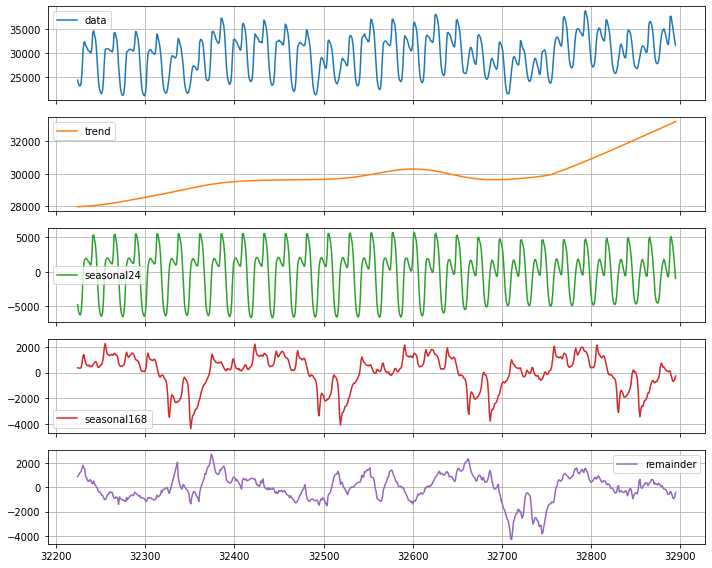

In [ ]:
sf.fitted_[0, 0].model_.tail(24 * 28).plot(subplots=True, grid=True)
plt.tight_layout()
plt.show()

We observe that there is a clear trend towards the high (orange line). This component would be predicted with the `AutoARIMA` model. We can also observe that every 24 hours and every `24 * 7` hours there is a very well defined pattern. These two components will be forecast separately using a `SeasonalNaive` model. 

#### Produce forecasts

To generate forecasts we only have to use the `predict` method specifying the forecast horizon (`h`). In addition, to calculate prediction intervals associated to the forecasts, we can include the parameter `level` that receives a list of levels of the prediction intervals we want to build. In this case we will only calculate the 90% forecast interval (`level=[90]`). 

In [ ]:
forecasts = sf.predict(h=24, level=[90])
forecasts.head()

,ds,MSTL,MSTL-lo-90,MSTL-hi-90
unique_id,,,,
PJM_Load_hourly,2002-01-01 01:00:00,29956.744141,29585.187500,30328.298828
PJM_Load_hourly,2002-01-01 02:00:00,29057.691406,28407.498047,29707.884766
PJM_Load_hourly,2002-01-01 03:00:00,28654.699219,27767.101562,29542.298828
PJM_Load_hourly,2002-01-01 04:00:00,28499.009766,27407.640625,29590.378906
PJM_Load_hourly,2002-01-01 05:00:00,28821.716797,27552.236328,30091.197266


Let's look at our forecasts graphically.

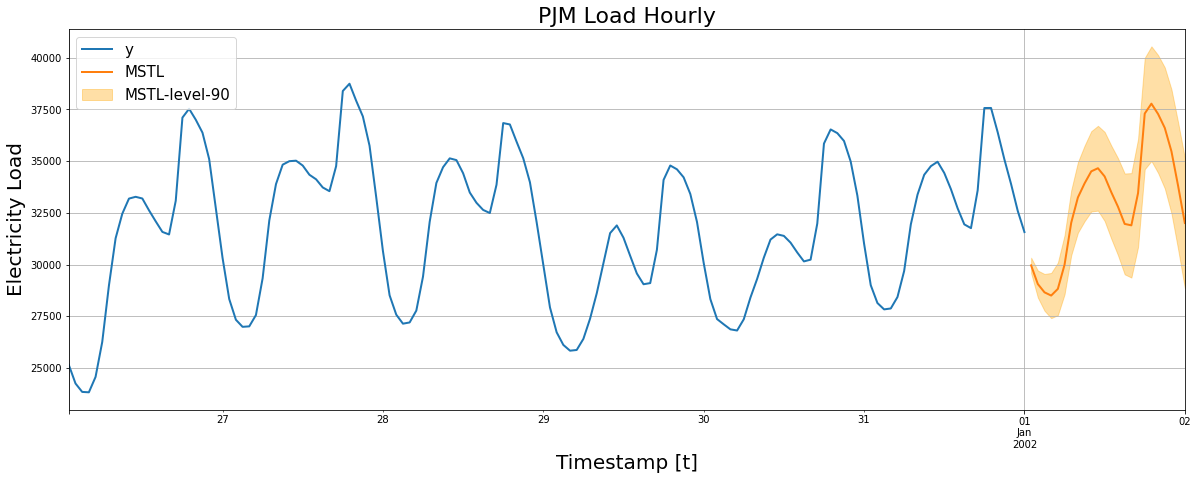

In [ ]:
_, ax = plt.subplots(1, 1, figsize = (20, 7))
df_plot = pd.concat([df, forecasts]).set_index('ds').tail(24 * 7)
df_plot[['y', 'MSTL']].plot(ax=ax, linewidth=2)
ax.fill_between(df_plot.index, 
                df_plot['MSTL-lo-90'], 
                df_plot['MSTL-hi-90'],
                alpha=.35,
                color='orange',
                label='MSTL-level-90')
ax.set_title('PJM Load Hourly', fontsize=22)
ax.set_ylabel('Electricity Load', fontsize=20)
ax.set_xlabel('Timestamp [t]', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()

In the next section we will plot different models so it is convenient to reuse the previous code with the following function. 

In [ ]:
def plot_forecasts(y_hist, y_true, y_pred, models):
    _, ax = plt.subplots(1, 1, figsize = (20, 7))
    y_true = y_true.merge(y_pred, how='left', on=['unique_id', 'ds'])
    df_plot = pd.concat([y_hist, y_true]).set_index('ds').tail(24 * 7)
    df_plot[['y'] + models].plot(ax=ax, linewidth=2)
    colors = ['orange', 'green', 'red']
    for model, color in zip(models, colors):
        ax.fill_between(df_plot.index, 
                        df_plot[f'{model}-lo-90'], 
                        df_plot[f'{model}-hi-90'],
                        alpha=.35,
                        color=color,
                        label=f'{model}-level-90')
    ax.set_title('PJM Load Hourly', fontsize=22)
    ax.set_ylabel('Electricity Load', fontsize=20)
    ax.set_xlabel('Timestamp [t]', fontsize=20)
    ax.legend(prop={'size': 15})
    ax.grid()

### Performance of the MSTL model

#### Split Train/Test sets

To validate the accuracy of the `MSTL` model, we will show its performance on unseen data. We will use a classical time series technique that consists of dividing the data into a training set and a test set. We will leave the last 24 observations (the last day) as the test set. So the model will train on `32,872` observations. 

In [ ]:
df_test = df.tail(24)
df_train = df.drop(df_test.index)

#### MSTL model

In addition to the `MSTL` model, we will include the `SeasonalNaive` model as a benchmark to validate the added value of the `MSTL` model. Including `StatsForecast` models is as simple as adding them to the list of models to be fitted.

In [ ]:
sf = StatsForecast(
    models=[mstl, SeasonalNaive(season_length=24)], # add SeasonalNaive model to the list
    freq='H'
)

To measure the fitting time we will use the `time` module. 

In [ ]:
from time import time

To retrieve the forecasts of the test set we only have to do fit and predict as before.

In [ ]:
init = time()
sf = sf.fit(df=df_train)
forecasts_test = sf.predict(h=len(df_test), level=[90])
end = time()
forecasts_test.head()

,ds,MSTL,MSTL-lo-90,MSTL-hi-90,SeasonalNaive,SeasonalNaive-lo-90,SeasonalNaive-hi-90
unique_id,,,,,,,
PJM_Load_hourly,2001-12-31 01:00:00,28345.212891,27973.570312,28716.853516,28326.0,23468.693359,33183.308594
PJM_Load_hourly,2001-12-31 02:00:00,27567.455078,26917.085938,28217.824219,27362.0,22504.693359,32219.306641
PJM_Load_hourly,2001-12-31 03:00:00,27260.001953,26372.138672,28147.865234,27108.0,22250.693359,31965.306641
PJM_Load_hourly,2001-12-31 04:00:00,27328.125000,26236.410156,28419.839844,26865.0,22007.693359,31722.306641
PJM_Load_hourly,2001-12-31 05:00:00,27640.673828,26370.773438,28910.572266,26808.0,21950.693359,31665.306641


In [ ]:
time_mstl = (end - init) / 60
print(f'MSTL Time: {time_mstl:.2f} minutes')

MSTL Time: 0.43 minutes


Then we were able to generate forecasts for the next 24 hours. Now let's look at the graphical comparison of the forecasts with the actual values.

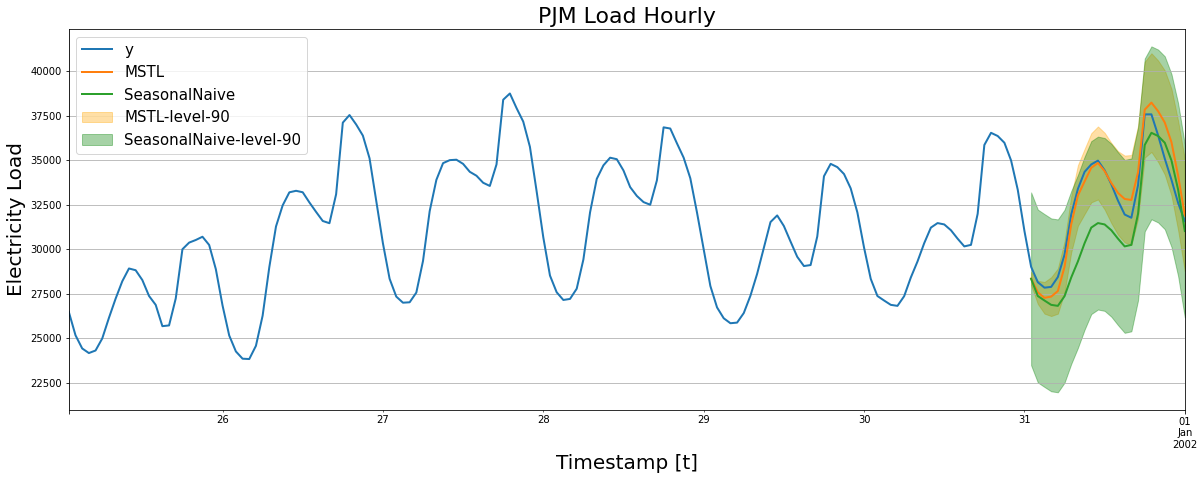

In [ ]:
plot_forecasts(df_train, df_test, forecasts_test, models=['MSTL', 'SeasonalNaive'])

Let's look at those produced only by `MSTL`. 

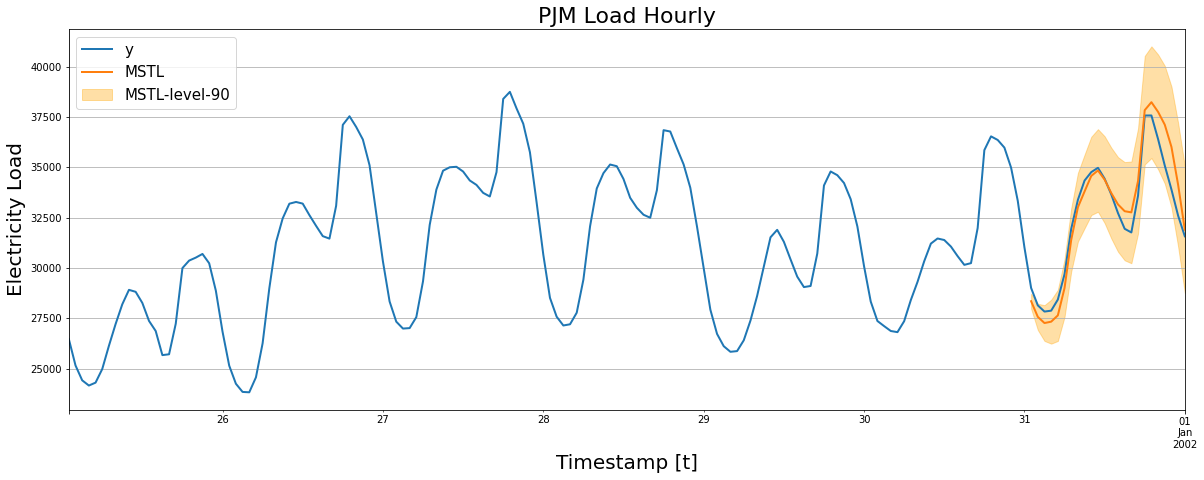

In [ ]:
plot_forecasts(df_train, df_test, forecasts_test, models=['MSTL'])

We note that `MSTL` produces very accurate forecasts that follow the behavior of the time series. Now let us calculate numerically the accuracy of the model. We will use the following metrics: `MAE`, `MAPE`, `MASE`, `RMSE`, `SMAPE`.

In [ ]:
from datasetsforecast.losses import (
    mae, mape, mase, rmse, smape
)

In [ ]:
def evaluate_performace(y_hist, y_true, y_pred, models):
    y_true = y_true.merge(y_pred, how='left', on=['unique_id', 'ds'])
    evaluation = {}
    for model in models:
        evaluation[model] = {}
        for metric in [mase, mae, mape, rmse, smape]:
            metric_name = metric.__name__
            if metric_name == 'mase':
                evaluation[model][metric_name] = metric(y_true['y'].values, 
                                                 y_true[model].values, 
                                                 y_hist['y'].values, seasonality=24)
            else:
                evaluation[model][metric_name] = metric(y_true['y'].values, y_true[model].values)
    return pd.DataFrame(evaluation).T

In [ ]:
evaluate_performace(df_train, df_test, forecasts_test, models=['MSTL', 'SeasonalNaive'])

,mase,mae,mape,rmse,smape
MSTL,0.341926,709.932048,2.182804,892.888012,2.162832
SeasonalNaive,0.894653,1857.541667,5.648190,2201.384101,5.868604


We observe that `MSTL` has an improvement of about 60% over the `SeasonalNaive` method in the test set measured in `MASE`.

#### Comparison with Prophet

One of the most widely used models for time series forecasting is `Prophet`. This model is known for its ability to model different seasonalities (weekly, daily yearly). We will use this model as a benchmark to see if the `MSTL` adds value for this time series. 

In [ ]:
from prophet import Prophet

# create prophet model
prophet = Prophet(interval_width=0.9)
init = time()
prophet.fit(df_train)
# produce forecasts
future = prophet.make_future_dataframe(periods=len(df_test), freq='H', include_history=False)
forecast_prophet = prophet.predict(future)
end = time()
# data wrangling
forecast_prophet = forecast_prophet[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
forecast_prophet.columns = ['ds', 'Prophet', 'Prophet-lo-90', 'Prophet-hi-90']
forecast_prophet.insert(0, 'unique_id', 'PJM_Load_hourly')
forecast_prophet.head()

DEBUG:cmdstanpy:input tempfile: /tmp/tmpc6f7_v9l/08tirxvt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpc6f7_v9l/gp60b_b1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27632', 'data', 'file=/tmp/tmpc6f7_v9l/08tirxvt.json', 'init=/tmp/tmpc6f7_v9l/gp60b_b1.json', 'output', 'file=/tmp/tmpc6f7_v9l/prophet_modelkou9navr/prophet_model-20221111002506.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:25:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:25:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,unique_id,ds,Prophet,Prophet-lo-90,Prophet-hi-90
0,PJM_Load_hourly,2001-12-31 01:00:00,25255.037078,20589.007557,30472.856691
1,PJM_Load_hourly,2001-12-31 02:00:00,23961.427979,19078.763798,28752.007690
2,PJM_Load_hourly,2001-12-31 03:00:00,23285.418846,18491.391041,28213.042892
3,PJM_Load_hourly,2001-12-31 04:00:00,23293.143264,18620.414846,28364.115196
4,PJM_Load_hourly,2001-12-31 05:00:00,24067.737572,19062.318724,29162.041606


In [ ]:
time_prophet = (end - init) / 60
print(f'Prophet Time: {time_prophet:.2f} minutes')

Prophet Time: 0.93 minutes


In [ ]:
times = pd.DataFrame({'model': ['MSTL', 'Prophet'], 'time (mins)': [time_mstl, time_prophet]})
times

,model,time (mins)
0,MSTL,0.425080
1,Prophet,0.928628


We observe that the time required for `Prophet` to perform the fit and predict pipeline is greater than `MSTL`. Let's look at the forecasts produced by `Prophet`.

In [ ]:
forecasts_test = forecasts_test.merge(forecast_prophet, how='left', on=['unique_id', 'ds'])

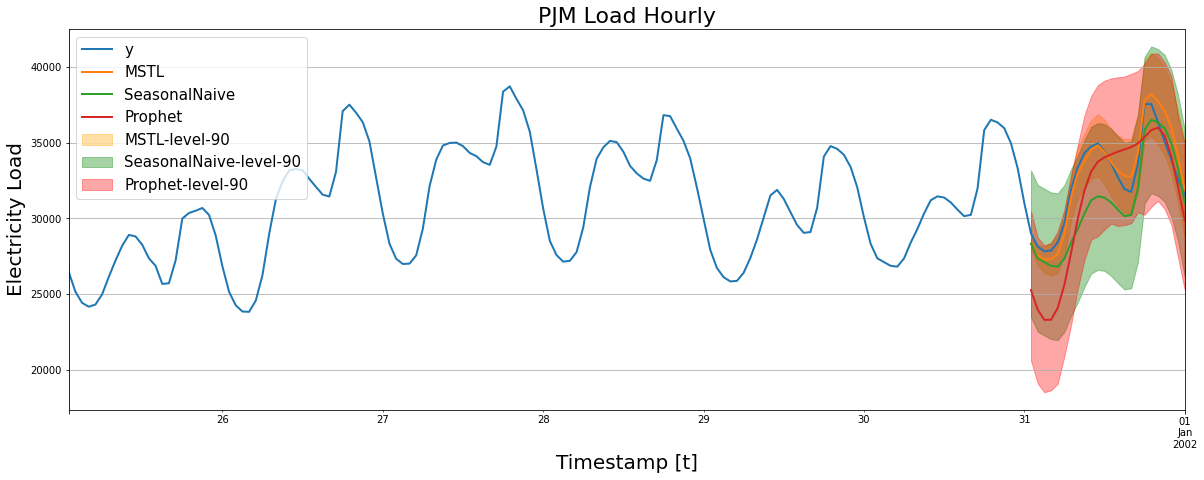

In [ ]:
plot_forecasts(df_train, df_test, forecasts_test, models=['MSTL', 'SeasonalNaive', 'Prophet'])

We note that `Prophet` is able to capture the overall behavior of the time series. However, in some cases it produces forecasts well below the actual value. It also does not correctly adjust the valleys. 

In [ ]:
evaluate_performace(df_train, df_test, forecasts_test, models=['MSTL', 'Prophet', 'SeasonalNaive'])

,mase,mae,mape,rmse,smape
MSTL,0.341926,709.932048,2.182804,892.888012,2.162832
Prophet,1.107472,2299.413375,7.427523,2742.792022,7.789355
SeasonalNaive,0.894653,1857.541667,5.648190,2201.384101,5.868604


In terms of accuracy, `Prophet` is not able to produce better forecasts than the `SeasonalNaive` model, however, the `MSTL` model improves `Prophet`'s forecasts by 69% (`MASE`).

#### Comparison with NeuralProphet

`NeuralProphet` is the version of `Prophet` using deep learning. This model is also capable of handling different seasonalities so we will also use it as a benchmark. 

In [ ]:
from neuralprophet import NeuralProphet

neuralprophet = NeuralProphet(quantiles=[0.05, 0.95])
init = time()
neuralprophet.fit(df_train.drop(columns='unique_id'))
future = neuralprophet.make_future_dataframe(df=df_train.drop(columns='unique_id'), periods=len(df_test))
forecast_np = neuralprophet.predict(future)
end = time()
forecast_np = forecast_np[['ds', 'yhat1', 'yhat1 5.0%', 'yhat1 95.0%']]
forecast_np.columns = ['ds', 'NeuralProphet', 'NeuralProphet-lo-90', 'NeuralProphet-hi-90']
forecast_np.insert(0, 'unique_id', 'PJM_Load_hourly')
forecast_np.head()

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.973% of the data.
INFO:NP.df_utils:Major frequency H corresponds to 99.973% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as H
INFO:NP.df_utils:Dataframe freq automatically defined as H
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 64
INFO:NP.config:Auto-set batch_size to 64
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 76
INFO:NP.config:Auto-set epochs to 76


  0%|          | 0/162 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:922: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)

  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:922: UserWarning: Using a target size (torch.Size([324, 1, 1])) that is different to the input size (torch.Size([324, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)

  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)



  0%|          | 0/162 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.03E-02, min: 1.82E-01
INFO:NP.utils_torch:lr-range-test results: steep: 5.03E-02, min: 1.82E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 5.81E-02
INFO:NP.forecaster:lr-range-test selected learning rate: 5.81E-02
Epoch[76/76]: 100%|██████████| 76/76 [02:17<00:00,  1.81s/it, SmoothL1Loss=0.00872, MAE=2.27e+3, RMSE=3.03e+3, Loss=0.00862, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.973% of the data.
INFO:NP.df_utils:Major frequency H corresponds to 99.973% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO:NP.df_utils:Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 95.833% of th

,unique_id,ds,NeuralProphet,NeuralProphet-lo-90,NeuralProphet-hi-90
0,PJM_Load_hourly,2001-12-31 01:00:00,25015.931641,22304.785156,27442.351562
1,PJM_Load_hourly,2001-12-31 02:00:00,24125.677734,21462.275391,26571.785156
2,PJM_Load_hourly,2001-12-31 03:00:00,23730.714844,20973.000000,26321.234375
3,PJM_Load_hourly,2001-12-31 04:00:00,23469.591797,20735.953125,26097.132812
4,PJM_Load_hourly,2001-12-31 05:00:00,23887.208984,21221.152344,26459.939453


In [ ]:
time_np = (end - init) / 60
print(f'Prophet Time: {time_np:.2f} minutes')

Prophet Time: 2.39 minutes


In [ ]:
times = times.append({'model': 'NeuralProphet', 'time (mins)': time_np}, ignore_index=True)
times

,model,time (mins)
0,MSTL,0.425080
1,Prophet,0.928628
2,NeuralProphet,2.393841


We observe that `NeuralProphet` requires a longer processing time than `Prophet` and `MSTL`.

In [ ]:
forecasts_test = forecasts_test.merge(forecast_np, how='left', on=['unique_id', 'ds'])

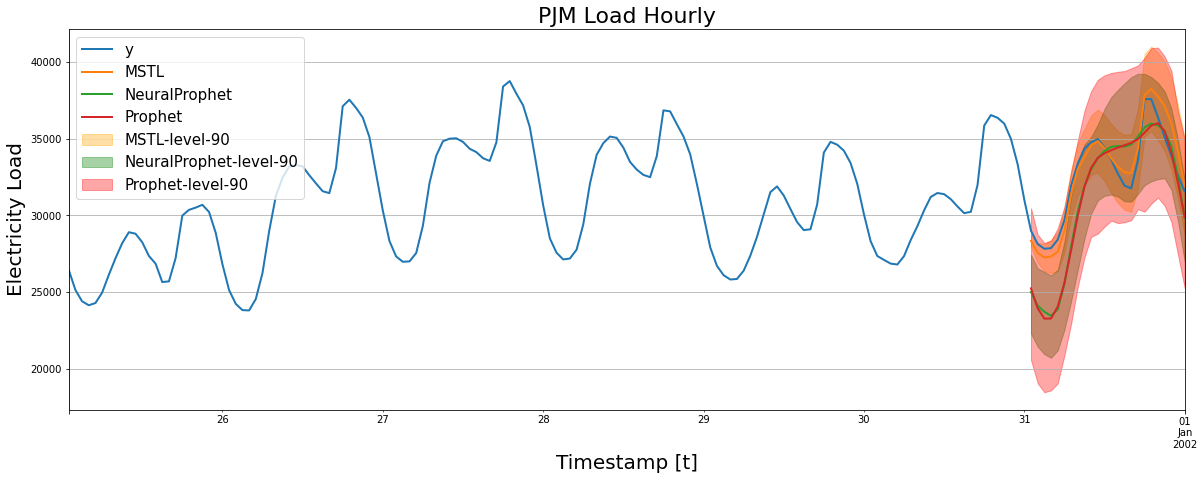

In [ ]:
plot_forecasts(df_train, df_test, forecasts_test, models=['MSTL', 'NeuralProphet', 'Prophet'])

The forecasts graph shows that `NeuralProphet` generates very similar results to `Prophet`, as expected. 

In [ ]:
evaluate_performace(df_train, df_test, forecasts_test, models=['MSTL', 'NeuralProphet', 'Prophet', 'SeasonalNaive'])

,mase,mae,mape,rmse,smape
MSTL,0.341926,709.932048,2.182804,892.888012,2.162832
NeuralProphet,1.089964,2263.060303,7.310210,2681.742759,7.651353
Prophet,1.107472,2299.413375,7.427523,2742.792022,7.789355
SeasonalNaive,0.894653,1857.541667,5.648190,2201.384101,5.868604


With respect to numerical evaluation, `NeuralProphet` improves the results of `Prohet`, as expected, however, `MSTL` improves over `NeuralProphet`'s foreacasts by 68% (`MASE`).

:::{.callout-important}
The performance of `NeuralProphet` can be improved using hyperparameter optimization, which can increase the fitting time significantly. In this example we show its performance with the default version.
:::

## Conclusion

In this post we introduced `MSTL`, a model originally developed by [Kasun Bandara, Rob Hyndman and Christoph Bergmeir](https://arxiv.org/abs/2107.13462) capable of handling time series with multiple seasonalities. We also showed that for the PJM electricity load time series offers better performance in time and accuracy than the `Prophet` and `NeuralProphet` models.

## References

- [Bandara, Kasun & Hyndman, Rob & Bergmeir, Christoph. (2021). “MSTL: A Seasonal-Trend Decomposition Algorithm for Time Series with Multiple Seasonal Patterns”](https://arxiv.org/abs/2107.13462).

